In [1]:
# okay so now I need to write some code that can fit a model
# and maybe the class can be defined in that script?
# and I'll have to import it in cannon model diagnostics.
# so at that point I'll need to remove redundant import statements
# from cannon_model_diagnostics


# cannon_model_diagnostics will need to import this script.
# then train_cannon_model imports this.
# but maybe that's fine?
# i'm really just making an objcet that's an extension
# of the cannon model object.
# probbaly called spectrum.py
# I think it's okay

In [45]:
import thecannon as tc
import astropy.units as u
import astropy.constants as c
from astropy.io import fits
from scipy.optimize import leastsq

# define clip size for each order (in pixels)
# used to generate training set
order_clip = 200

# load wavelength data
w_filename = './data/cks-spectra/cks-k00002_rj122.92.fits' # can be any r chip file
w_data = fits.open(w_filename)[2].data[:, :-1] # require even number of elements
w_data = w_data[:, order_clip:-1*order_clip] # clip 5% on each side

# define wavelength limits for masks
sodium_wmin, sodium_wmax = 5889.5, 5896.5
max_v_shift = 30*u.km/u.s 
telluric_wmin = (6270*u.angstrom*(1-max_v_shift/c.c)).value
telluric_wmax = (6310*u.angstrom*(1+max_v_shift/c.c)).value

class SingleOrderSpectrum(object):
    def __init__(self, flux, sigma, order_number):
        # store spectrum information
        self.flux = np.array(flux[order_clip:-1*order_clip])
        self.sigma = np.array(sigma[order_clip:-1*order_clip])
        self.order_number = order_number
        # store order wavelength
        self.w = w_data[order_number-1]
        # compute wavelength mask
        sodium_mask = np.where((self.w>sodium_wmin) & (self.w<sodium_wmax))[0]
        telluric_mask = np.where((self.w>telluric_wmin) & (self.w<telluric_wmax))[0]
        self.mask = np.array(list(sodium_mask) + list(telluric_mask))
        # store relevant cannon model
        model_path = './data/cannon_models/rchip_order{}.model'.format(order_number)
        self.cannon_model = tc.CannonModel.read(model_path)
    
    def fit_single_star(self):
        """
        Run the test step on the spectra
        (similar to the Cannon 2 test step, 
        but we mask the sodium + telluric lines)
        Args:
            flux (np.array): normalized flux data
            sigma (np.array): flux error data
            single_star_model (tc.CannonModle): Cannon model to use for fitting
        """
        # mask out sodium, telluric features
        sigma_for_fit = self.sigma.copy()
        if len(self.mask)>0:
            sigma_for_fit[self.mask] = np.inf
            
        # single star model goodness-of-fit
        def residuals(param):
            """
            per-pixel chi-squared for a given set of Cannon labels
                Args:
                    param (np.array): teff, logg, met, vsini values
                Returns:
                    resid (np.array): per pixel chi-squared
            """
            # re-parameterize from log(vbroad) to vbroad for Cannon
            cannon_param = param.copy()
            cannon_param[-1] = 10**cannon_param[-1]
            # compute chisq
            model = self.cannon_model(cannon_param)
            weights = 1/np.sqrt(sigma_for_fit**2+self.cannon_model.s2)
            resid = weights * (model - self.flux)
            return resid
        
        # initial labels from cannon model
        initial_labels = self.cannon_model._fiducials.copy()
        # re-parameterize from vbroad to log(vroad) in optimizer
        initial_labels[-1] = np.log10(initial_labels[-1]) 
        # perform fit
        result = leastsq(residuals,x0=initial_labels)
        self.chisq_single = np.sum(residuals(fit_labels)**2)
        # re-parameterize from log(vbroad) to vbroad
        self.cannon_labels = result[0].copy()
        self.cannon_labels[-1] = 10**self.cannon_labels[-1]

        

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


stty: 2024-04-09 11:50:43,714 [DEBUG] Couldn't get screen size. Progressbar may look odd.
stdin isn't a terminal
2024-04-09 11:50:43,716 [INFO] Running test step on 1 spectra


[=                                                                                                   ] 100% (0s)                         


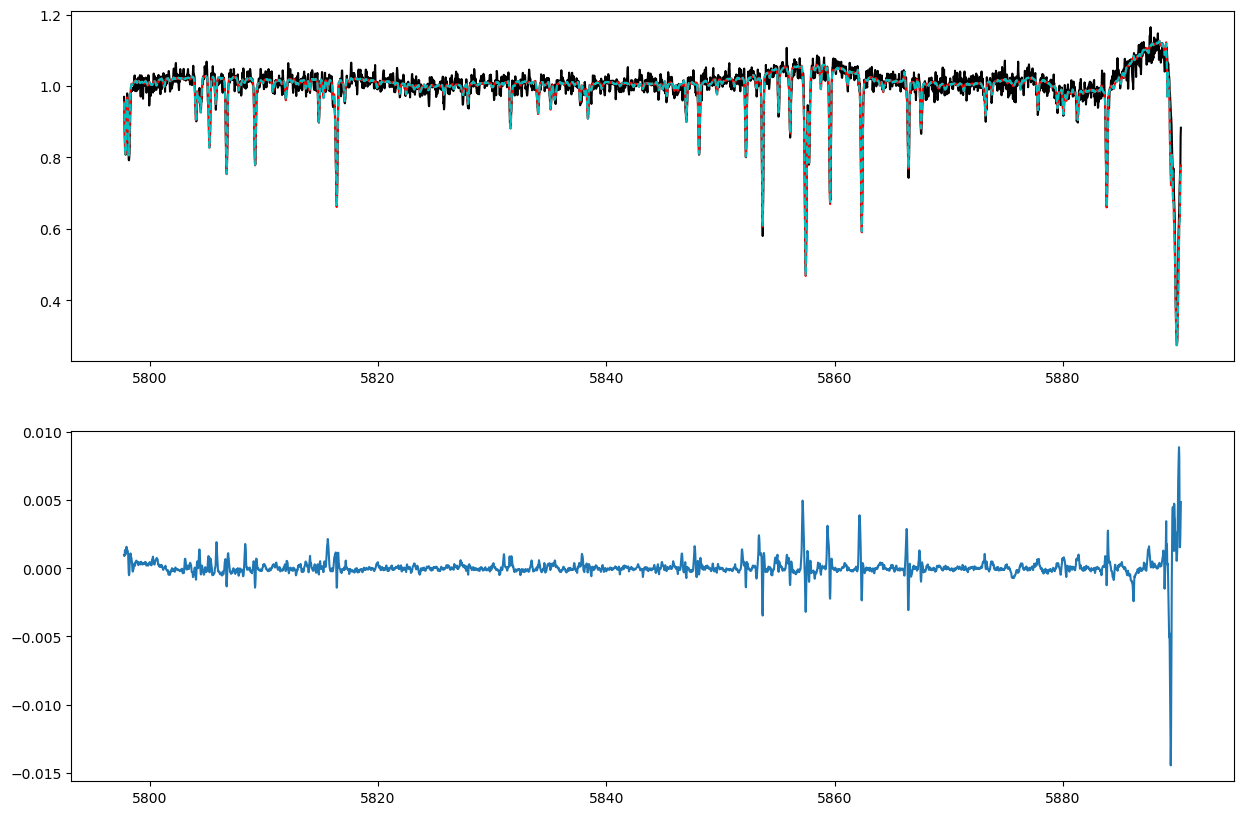

In [51]:
# check that telluric + calcium orders
# this all seems to be working.
# I think I just need to integrate it into the python scripts now.
import pandas as pd
%pylab inline

training_flux = pd.read_csv('./data/cks-spectra_dataframes/training_flux_order11.csv')
training_sigma = pd.read_csv('./data/cks-spectra_dataframes/training_sigma_order11.csv')
flux = training_flux['K00001']
sigma = training_sigma['K00001']
spec = SingleOrderSpectrum(flux, sigma, 11)
spec.fit_single_star()

result = spec.cannon_model.test(spec.flux, 1/spec.sigma**2)
model = result[2][0]['model_flux']

figure(figsize=(15,10))
subplot(211)
plot(spec.w, spec.flux, 'k-')
plot(spec.w, model, 'r-')
plot(spec.w, spec.cannon_model(spec.cannon_labels), color='c', ls='--')
subplot(212)
# plot(spec.w, spec.flux - model, 'r-')
# plot(spec.w, spec.flux - spec.cannon_model(spec.cannon_labels), color='c', ls='--')
plot(spec.w, model - spec.cannon_model(spec.cannon_labels))
# the fits are most different at the masked part- this makes sense :)

# now I'll plot the residuals